# Node2Vec

- GPU 사용을 위한 CUDA 버전에 따른 설치는 여기서 확인: https://pytorch.org/get-started/previous-versions/

## 라이브러리 설치

In [14]:
#%pip install torch

In [16]:
import torch
torch.__version__

'2.3.1+cu121'

In [ ]:
%pip install torch-geometric \
  torch-sparse \
  torch-scatter \
  torch-cluster \
  pyg-lib \
  -f https://data.pyg.org/whl/torch-{torch.__version__}.html

## 라이브러리 불러오기

In [18]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import Node2Vec

## Cora 데이터셋

In [19]:
dataset = Planetoid(root="dataset", name="Cora")
data = dataset[0]

# Print information about the dataset
print(f'*Dataset: {dataset}')
print('---------------')
print(f'No. of graphs: {len(dataset)}')
print(f'No. of nodes: {data.x.shape[0]}')
print(f'No. of features: {dataset.num_features}')
print(f'No. of classes: {dataset.num_classes}')

# Print information about the graph
print(f'\n*Graph:')
print('-------')
print(f'Edges directed: {data.is_directed()}')
print(f'Graph isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph loops: {data.has_self_loops()}')

*Dataset: Cora()
---------------
No. of graphs: 1
No. of nodes: 2708
No. of features: 1433
No. of classes: 7

*Graph:
-------
Edges directed: False
Graph isolated nodes: False
Graph loops: False


## Node2Vec

In [20]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = Node2Vec(
    data.edge_index,
    embedding_dim=128,
    walk_length=20,
    context_size=10,
    walks_per_node=10,
    num_negative_samples=1,
    p=1.0,
    q=1.0,
    sparse=True,
).to(device)

## Model & Optimizer

In [21]:
num_workers = 4 if sys.platform == 'linux' else 0
loader = model.loader(batch_size=128, shuffle=True, num_workers=num_workers)
optimizer = torch.optim.SparseAdam(list(model.parameters()), lr=0.01)

## Train & Test

Epoch: 010, Loss: 1.7362, Acc: 0.3920
Epoch: 020, Loss: 0.9693, Acc: 0.6350
Epoch: 030, Loss: 0.8689, Acc: 0.6960
Epoch: 040, Loss: 0.8440, Acc: 0.7000
Epoch: 050, Loss: 0.8334, Acc: 0.7070
Epoch: 060, Loss: 0.8289, Acc: 0.7030
Epoch: 070, Loss: 0.8274, Acc: 0.6990
Epoch: 080, Loss: 0.8256, Acc: 0.6970
Epoch: 090, Loss: 0.8252, Acc: 0.7140
Epoch: 100, Loss: 0.8247, Acc: 0.7180


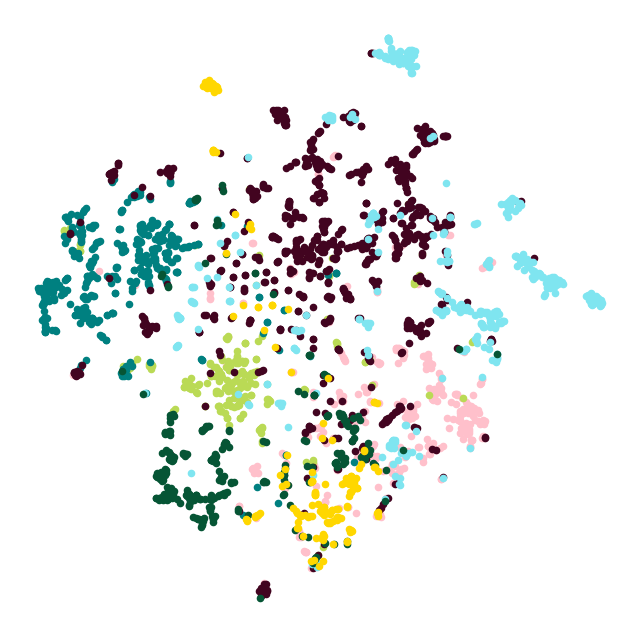

In [22]:
def train():
    model.train()
    total_loss = 0
    for pos_rw, neg_rw in loader:
        optimizer.zero_grad()
        loss = model.loss(pos_rw.to(device), neg_rw.to(device))
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)


@torch.no_grad()
def test():
    model.eval()
    z = model()
    acc = model.test(
        train_z=z[data.train_mask],
        train_y=data.y[data.train_mask],
        test_z=z[data.test_mask],
        test_y=data.y[data.test_mask],
        max_iter=150,
    )
    return acc


for epoch in range(1, 101):
    loss = train()
    acc = test()
    if epoch % 10 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}, Acc: {acc:.4f}')


@torch.no_grad()
def plot_points(colors):
    model.eval()
    z = model().cpu().numpy()
    z = TSNE(n_components=2).fit_transform(z)
    y = data.y.cpu().numpy()

    plt.figure(figsize=(8, 8))
    for i in range(dataset.num_classes):
        plt.scatter(z[y == i, 0], z[y == i, 1], s=20, color=colors[i])
    plt.axis('off')
    plt.show()


colors = [
    '#ffc0cb', '#bada55', '#008080', '#420420', '#7fe5f0', '#065535', '#ffd700'
]
plot_points(colors)